<a href="https://colab.research.google.com/github/kridtapon/Liquidity-Trap-Reversal-LTR-/blob/main/Liquidity_Trap_Reversal_(LTR).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.1 MB/s eta 0:00:00


In [3]:
pip install --upgrade yfinance

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to detect liquidity grabs (sweeps of previous highs/lows)
def detect_liquidity_grab(df, lookback=20, shift_hl=1):
    """
    Identify liquidity grabs where price sweeps swing highs/lows and quickly reverses.
    """
    df['Swing_High'] = df['High'].rolling(lookback).max()
    df['Swing_Low'] = df['Low'].rolling(lookback).min()
    df['Liquidity_Grab_High'] = (df['High'] > df['Swing_High'].shift(shift_hl))
    df['Liquidity_Grab_Low'] = (df['Low'] < df['Swing_Low'].shift(shift_hl))
    return df

# Function to detect Order Blocks (last opposite candle before strong move)
def detect_strong_move(df, shift_bull=1, shift_bear=1):
    """
    Identify order blocks based on previous opposite candle before a strong move.
    """
    df['Bullish_OB'] = (df['Close'].shift(shift_bull) < df['Open'].shift(shift_bull)) & (df['Close'] > df['Open'])
    df['Bearish_OB'] = (df['Close'].shift(shift_bear) > df['Open'].shift(shift_bear)) & (df['Close'] < df['Open'])
    return df

# Download stock data
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Apply indicators and strategy conditions
df = detect_liquidity_grab(df, lookback=20, shift_hl=1)
df = detect_strong_move(df, shift_bull=1, shift_bear=1)

# Filter for backtest period
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry & Exit Conditions
# Bullish Entry: Liquidity grab + Order block
df['Entry'] = (
    df['Liquidity_Grab_Low'] | df['Bullish_OB']
)

# Bearish Exit: Liquidity grab + Order block
df['Exit'] = (
    df['Liquidity_Grab_High'] | df['Bearish_OB']
)

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            77242.084209
Total Return [%]                       -22.757916
Benchmark Return [%]                   180.172898
Max Gross Exposure [%]                      100.0
Total Fees Paid                       34353.80714
Max Drawdown [%]                        69.042265
Max Drawdown Duration                      1226.0
Total Trades                                  268
Total Closed Trades                           268
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                             41.41791
Best Trade [%]                          21.526824
Worst Trade [%]                        -15.136112
Avg Winning Trade [%]                    2.720428
Avg Losing Trade [%]                    -1.994492


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Function to detect liquidity grabs (sweeps of previous highs/lows)
def detect_liquidity_grab(df, lookback=20, shift_hl=1):
    lookback = int(lookback)  # Ensure lookback is an integer
    df['Swing_High'] = df['High'].rolling(lookback).max()
    df['Swing_Low'] = df['Low'].rolling(lookback).min()
    df['Liquidity_Grab_High'] = (df['High'] > df['Swing_High'].shift(shift_hl))
    df['Liquidity_Grab_Low'] = (df['Low'] < df['Swing_Low'].shift(shift_hl))
    return df

# Function to detect opposite candle before strong move
def detect_strong_move(df, shift_bull=1, shift_bear=1):
    shift_bull = int(shift_bull)  # Ensure shift_bull is an integer
    shift_bear = int(shift_bear)  # Ensure shift_bear is an integer
    df['Bullish_OB'] = (df['Close'].shift(shift_bull) < df['Open'].shift(shift_bull)) & (df['Close'] > df['Open'])
    df['Bearish_OB'] = (df['Close'].shift(shift_bear) > df['Open'].shift(shift_bear)) & (df['Close'] < df['Open'])
    return df

# Download stock data
symbol = 'GC=F'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define a grid of parameter values to test
lookback_values = range(5, 30, 2)
shift_hl_values = range(1, 20, 2)
shift_bull_values = range(1, 20, 2)
shift_bear_values = range(1, 20, 2)

# Create all possible combinations of parameters
param_combinations = list(product(lookback_values, shift_hl_values, shift_bull_values, shift_bear_values))

# Store results
results = []

# Perform the grid search
for lookback, shift_hl, shift_bull, shift_bear in param_combinations:
    # Apply indicators with the current parameters
    df_temp = df.copy()
    df_temp = detect_liquidity_grab(df_temp, lookback=lookback, shift_hl=shift_hl)
    df_temp = detect_strong_move(df_temp, shift_bull=shift_bull, shift_bear=shift_bear)

    # Filter for backtest period
    df_filtered = df_temp[(df_temp.index.year >= 2020) & (df_temp.index.year <= 2025)]

    # Define Entry & Exit Conditions
    df_filtered['Entry'] = (
        df_filtered['Liquidity_Grab_Low'] | df_filtered['Bullish_OB']
    )

    df_filtered['Exit'] = (
        df_filtered['Liquidity_Grab_High'] | df_filtered['Bearish_OB']
    )

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=df_filtered['Entry'],
        exits=df_filtered['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    stats = portfolio.stats()
    results.append((lookback, shift_hl, shift_bull, shift_bear, stats['Total Return [%]']))

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results, columns=['lookback', 'shift_hl', 'shift_bull', 'shift_bear', 'Total Return [%]'])

# Find the best parameter combination based on total return
best_params = results_df.loc[results_df['Total Return [%]'].idxmax()]

# Output the best parameters and the corresponding performance
print(f"Best Parameters:\nLookback: {best_params['lookback']}\nShift HL: {best_params['shift_hl']}\nShift Bull: {best_params['shift_bull']}\nShift Bear: {best_params['shift_bear']}")
print(f"Best Total Return: {best_params['Total Return [%]']}")

# Ensure the parameters are integers
lookback = int(best_params['lookback'])
shift_hl = int(best_params['shift_hl'])
shift_bull = int(best_params['shift_bull'])
shift_bear = int(best_params['shift_bear'])

# Plot equity curve for the best parameter set
best_df = df.copy()
best_df = detect_liquidity_grab(best_df, lookback=lookback, shift_hl=shift_hl)
best_df = detect_strong_move(best_df, shift_bull=shift_bull, shift_bear=shift_bear)

# Filter data for the test period (2020-2025)
best_df = best_df[(best_df.index.year >= 2020) & (best_df.index.year <= 2025)]

best_df['Entry'] = (
    best_df['Liquidity_Grab_Low'] | best_df['Bullish_OB']
)

best_df['Exit'] = (
    best_df['Liquidity_Grab_High'] | best_df['Bearish_OB']
)

portfolio_best = vbt.Portfolio.from_signals(
    close=best_df['Close'],
    entries=best_df['Entry'],
    exits=best_df['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio_best.plot().show()

print(portfolio_best.stats())

YF.download() has changed argument auto_adjust default to True


Streaming output truncated to the last 5000 lines.
<ipython-input-4-ecc0dc529dc2>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Entry'] = (
<ipython-input-4-ecc0dc529dc2>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Exit'] = (
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:

Best Parameters:
Lookback: 23.0
Shift HL: 7.0
Shift Bull: 19.0
Shift Bear: 13.0
Best Total Return: 87.42315944922976


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           187423.159449
Total Return [%]                        87.423159
Benchmark Return [%]                    72.463099
Max Gross Exposure [%]                      100.0
Total Fees Paid                      29371.898413
Max Drawdown [%]                          12.2368
Max Drawdown Duration                       230.0
Total Trades                                   99
Total Closed Trades                            99
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            57.575758
Best Trade [%]                          11.827803
Worst Trade [%]                          -2.95259
Avg Winning Trade [%]                     1.77284
Avg Losing Trade [%]                     -0.85638


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



In [16]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Function to detect liquidity grabs (sweeps of previous highs/lows)
def detect_liquidity_grab(df, lookback=20, shift_hl=1):
    lookback = int(lookback)  # Ensure lookback is an integer
    df['Swing_High'] = df['High'].rolling(lookback).max()
    df['Swing_Low'] = df['Low'].rolling(lookback).min()
    df['Liquidity_Grab_High'] = (df['High'] > df['Swing_High'].shift(shift_hl))
    df['Liquidity_Grab_Low'] = (df['Low'] < df['Swing_Low'].shift(shift_hl))
    return df

# Function to detect opposite candle before strong move
def detect_strong_move(df, shift_bull=1, shift_bear=1):
    shift_bull = int(shift_bull)  # Ensure shift_bull is an integer
    shift_bear = int(shift_bear)  # Ensure shift_bear is an integer
    df['Bullish_OB'] = (df['Close'].shift(shift_bull) < df['Open'].shift(shift_bull)) & (df['Close'] > df['Open'])
    df['Bearish_OB'] = (df['Close'].shift(shift_bear) > df['Open'].shift(shift_bear)) & (df['Close'] < df['Open'])
    return df

# Download stock data
symbol = 'GC=F'
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define a grid of parameter values to test
lookback_values = range(5, 30, 2)
shift_hl_values = range(1, 20, 2)
shift_bull_values = range(1, 20, 2)
shift_bear_values = range(1, 20, 2)

# Create all possible combinations of parameters
param_combinations = list(product(lookback_values, shift_hl_values, shift_bull_values, shift_bear_values))

# Store results
results = []

# Perform the grid search
for lookback, shift_hl, shift_bull, shift_bear in param_combinations:
    # Apply indicators with the current parameters
    df_temp = df.copy()
    df_temp = detect_liquidity_grab(df_temp, lookback=lookback, shift_hl=shift_hl)
    df_temp = detect_strong_move(df_temp, shift_bull=shift_bull, shift_bear=shift_bear)

    # Filter for backtest period
    df_filtered = df_temp[(df_temp.index.year >= 2020) & (df_temp.index.year <= 2025)]

    # Define Entry & Exit Conditions
    df_filtered['Entry'] = (
        df_filtered['Liquidity_Grab_Low'] & df_filtered['Bullish_OB']
    )

    df_filtered['Exit'] = (
        df_filtered['Liquidity_Grab_High'] & df_filtered['Bearish_OB']
    )

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_filtered['Close'],
        entries=df_filtered['Entry'],
        exits=df_filtered['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    stats = portfolio.stats()
    results.append((lookback, shift_hl, shift_bull, shift_bear, stats['Total Return [%]']))

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results, columns=['lookback', 'shift_hl', 'shift_bull', 'shift_bear', 'Total Return [%]'])

# Find the best parameter combination based on total return
best_params = results_df.loc[results_df['Total Return [%]'].idxmax()]

# Output the best parameters and the corresponding performance
print(f"Best Parameters:\nLookback: {best_params['lookback']}\nShift HL: {best_params['shift_hl']}\nShift Bull: {best_params['shift_bull']}\nShift Bear: {best_params['shift_bear']}")
print(f"Best Total Return: {best_params['Total Return [%]']}")

# Ensure the parameters are integers
lookback = int(best_params['lookback'])
shift_hl = int(best_params['shift_hl'])
shift_bull = int(best_params['shift_bull'])
shift_bear = int(best_params['shift_bear'])

# Plot equity curve for the best parameter set
best_df = df.copy()
best_df = detect_liquidity_grab(best_df, lookback=lookback, shift_hl=shift_hl)
best_df = detect_strong_move(best_df, shift_bull=shift_bull, shift_bear=shift_bear)

# Filter data for the test period (2020-2025)
best_df = best_df[(best_df.index.year >= 2020) & (best_df.index.year <= 2025)]

best_df['Entry'] = (
    best_df['Liquidity_Grab_Low'] & best_df['Bullish_OB']
)

best_df['Exit'] = (
    best_df['Liquidity_Grab_High'] & best_df['Bearish_OB']
)

portfolio_best = vbt.Portfolio.from_signals(
    close=best_df['Close'],
    entries=best_df['Entry'],
    exits=best_df['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio_best.plot().show()

print(portfolio_best.stats())

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

<ipython-input-16-c82f1ad0118c>:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-c82f1ad0118c>:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/lo

Best Parameters:
Lookback: 7.0
Shift HL: 7.0
Shift Bull: 17.0
Shift Bear: 13.0
Best Total Return: 78.84743379823863


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           178847.433798
Total Return [%]                        78.847434
Benchmark Return [%]                    72.463099
Max Gross Exposure [%]                      100.0
Total Fees Paid                        6678.15276
Max Drawdown [%]                        11.738175
Max Drawdown Duration                       233.0
Total Trades                                   25
Total Closed Trades                            24
Total Open Trades                               1
Open Trade PnL                        2340.539653
Win Rate [%]                                 75.0
Best Trade [%]                          17.746993
Worst Trade [%]                         -5.527637
Avg Winning Trade [%]                    4.170507
Avg Losing Trade [%]                    -2.531876


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



[*********************100%***********************]  1 of 1 completed


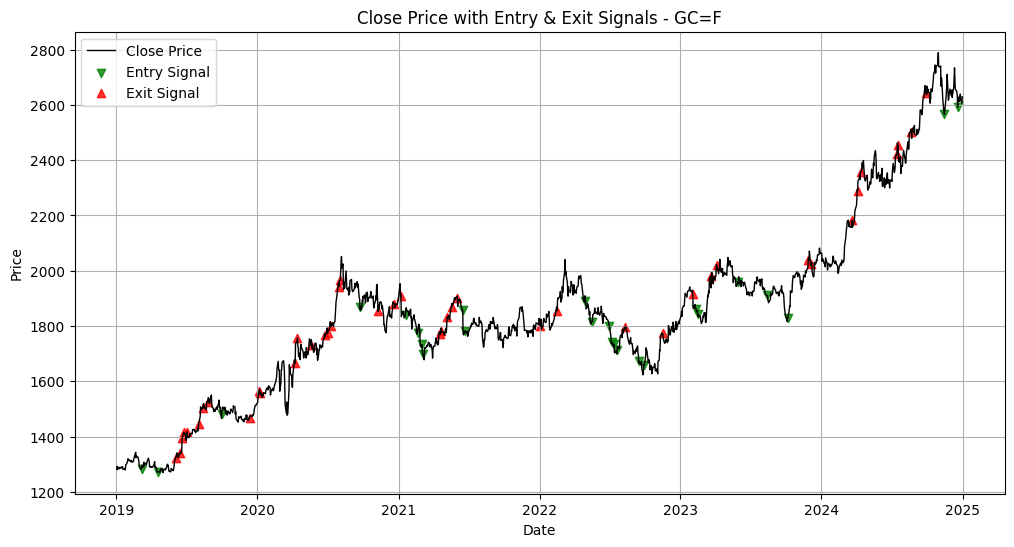

In [15]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to detect liquidity grabs (sweeps of previous highs/lows)
def detect_liquidity_grab(df, lookback=20, shift_hl=1):
    lookback = int(lookback)  # Ensure lookback is an integer
    df['Swing_High'] = df['High'].rolling(lookback).max()
    df['Swing_Low'] = df['Low'].rolling(lookback).min()
    df['Liquidity_Grab_High'] = (df['High'] > df['Swing_High'].shift(shift_hl))
    df['Liquidity_Grab_Low'] = (df['Low'] < df['Swing_Low'].shift(shift_hl))
    return df

# Function to detect Order Blocks (last opposite candle before strong move)
def detect_strong_move(df, shift_bull=1, shift_bear=1):
    shift_bull = int(shift_bull)  # Ensure shift_bull is an integer
    shift_bear = int(shift_bear)  # Ensure shift_bear is an integer
    df['Bullish_OB'] = (df['Close'].shift(shift_bull) < df['Open'].shift(shift_bull)) & (df['Close'] > df['Open'])
    df['Bearish_OB'] = (df['Close'].shift(shift_bear) > df['Open'].shift(shift_bear)) & (df['Close'] < df['Open'])
    return df

# Download stock data
symbol = 'GC=F'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Apply indicators
df = detect_liquidity_grab(df)
df = detect_strong_move(df)

# Define Entry & Exit conditions
df['Entry'] = df['Liquidity_Grab_Low'] & df['Bullish_OB']
df['Exit'] = df['Liquidity_Grab_High'] & df['Bearish_OB']

# Plot Close Price
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)

# Plot Entries (Green)
plt.scatter(df.index[df['Entry']], df['Close'][df['Entry']], color='green', label='Entry Signal', marker='v', alpha=0.8)

# Plot Exits (Red)
plt.scatter(df.index[df['Exit']], df['Close'][df['Exit']], color='red', label='Exit Signal', marker='^', alpha=0.8)

plt.legend()
plt.title(f'Close Price with Entry & Exit Signals - {symbol}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()


[*********************100%***********************]  1 of 1 completed


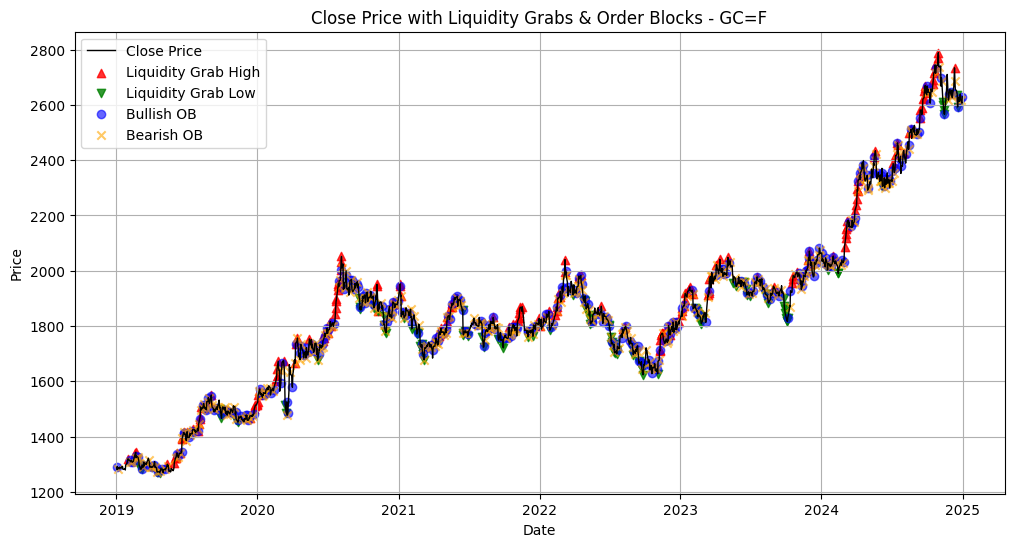

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to detect liquidity grabs (sweeps of previous highs/lows)
def detect_liquidity_grab(df, lookback=20, shift_hl=1):
    lookback = int(lookback)  # Ensure lookback is an integer
    df['Swing_High'] = df['High'].rolling(lookback).max()
    df['Swing_Low'] = df['Low'].rolling(lookback).min()
    df['Liquidity_Grab_High'] = (df['High'] > df['Swing_High'].shift(shift_hl))
    df['Liquidity_Grab_Low'] = (df['Low'] < df['Swing_Low'].shift(shift_hl))
    return df

# Function to detect Order Blocks (last opposite candle before strong move)
def detect_strong_move(df, shift_bull=1, shift_bear=1):
    shift_bull = int(shift_bull)  # Ensure shift_bull is an integer
    shift_bear = int(shift_bear)  # Ensure shift_bear is an integer
    df['Bullish_OB'] = (df['Close'].shift(shift_bull) < df['Open'].shift(shift_bull)) & (df['Close'] > df['Open'])
    df['Bearish_OB'] = (df['Close'].shift(shift_bear) > df['Open'].shift(shift_bear)) & (df['Close'] < df['Open'])
    return df

# Download stock data
symbol = 'GC=F'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Ensure correct column names
df = df.rename(columns={'Adj Close': 'Close'})

# Apply indicators
df = detect_liquidity_grab(df)
df = detect_strong_move(df)

# Plot Close Price
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)

# Plot Liquidity Grabs (red for highs, green for lows)
plt.scatter(df.index[df['Liquidity_Grab_High']], df['Close'][df['Liquidity_Grab_High']], color='red', label='Liquidity Grab High', marker='^', alpha=0.8)
plt.scatter(df.index[df['Liquidity_Grab_Low']], df['Close'][df['Liquidity_Grab_Low']], color='green', label='Liquidity Grab Low', marker='v', alpha=0.8)

# Plot Order Blocks (blue for bullish, orange for bearish)
plt.scatter(df.index[df['Bullish_OB']], df['Close'][df['Bullish_OB']], color='blue', label='Bullish OB', marker='o', alpha=0.6)
plt.scatter(df.index[df['Bearish_OB']], df['Close'][df['Bearish_OB']], color='orange', label='Bearish OB', marker='x', alpha=0.6)

plt.legend()
plt.title(f'Close Price with Liquidity Grabs & Order Blocks - {symbol}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()


[*********************100%***********************]  1 of 1 completed


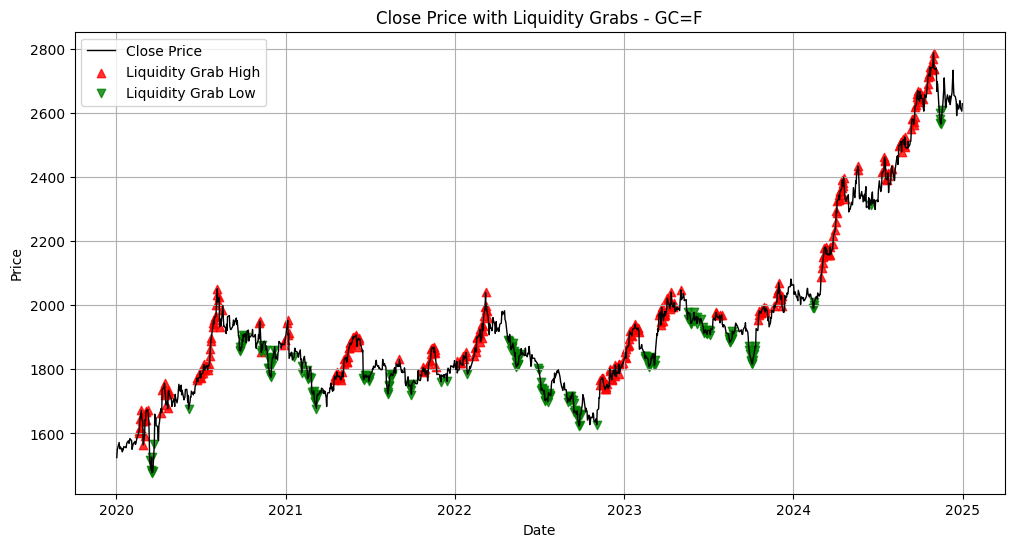

In [12]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to detect liquidity grabs (sweeps of previous highs/lows)
def detect_liquidity_grab(df, lookback=20, shift_hl=10):
    df['Swing_High'] = df['High'].rolling(lookback).max()
    df['Swing_Low'] = df['Low'].rolling(lookback).min()
    df['Liquidity_Grab_High'] = df['High'] > df['Swing_High'].shift(shift_hl)
    df['Liquidity_Grab_Low'] = df['Low'] < df['Swing_Low'].shift(shift_hl)
    return df

# Download stock data
symbol = 'GC=F'
start_date = '2020-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Apply Liquidity Grab Detection
df = detect_liquidity_grab(df)

# Plot Close Price
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)

# Plot Liquidity Grabs (red for highs, green for lows)
plt.scatter(df.index[df['Liquidity_Grab_High']], df['Close'][df['Liquidity_Grab_High']],
            color='red', label='Liquidity Grab High', marker='^', alpha=0.8)
plt.scatter(df.index[df['Liquidity_Grab_Low']], df['Close'][df['Liquidity_Grab_Low']],
            color='green', label='Liquidity Grab Low', marker='v', alpha=0.8)

plt.legend()
plt.title(f'Close Price with Liquidity Grabs - {symbol}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()


[*********************100%***********************]  1 of 1 completed


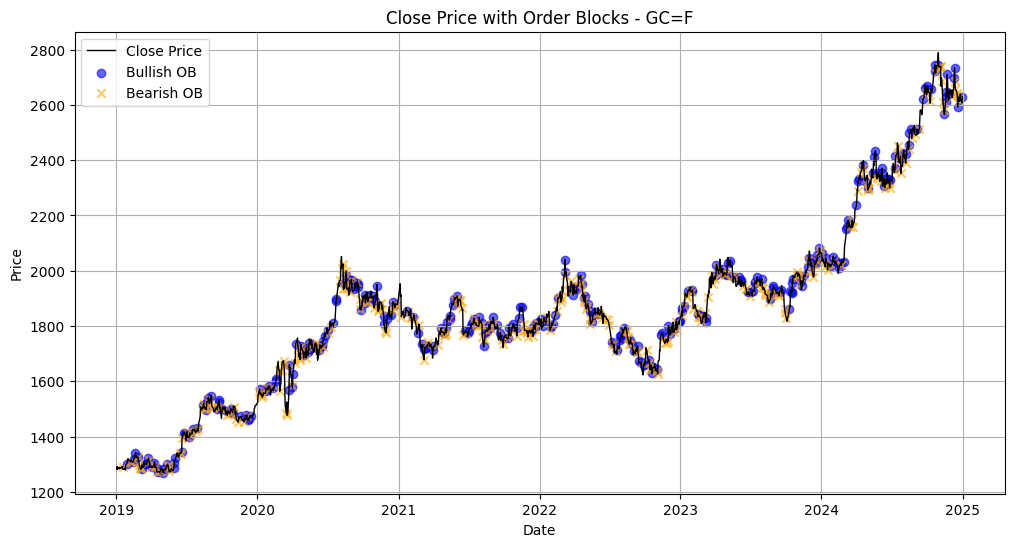

In [10]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Function to detect opposite candle before strong move
def detect_strong_move(df, shift_bull=10, shift_bear=10):
    df['Bullish_OB'] = (df['Close'].shift(shift_bull) < df['Open'].shift(shift_bull)) & (df['Close'] > df['Open'])
    df['Bearish_OB'] = (df['Close'].shift(shift_bear) > df['Open'].shift(shift_bear)) & (df['Close'] < df['Open'])
    return df

# Download stock data
symbol = 'GC=F'
start_date = '2019-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Ensure correct column names
df = df.rename(columns={'Adj Close': 'Close'})

# Apply Order Block Detection
df = detect_strong_move(df)

# Plot Close Price
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Close'], label='Close Price', color='black', linewidth=1)

# Plot Order Blocks (blue for bullish, orange for bearish)
plt.scatter(df.index[df['Bullish_OB']], df['Close'][df['Bullish_OB']],
            color='blue', label='Bullish OB', marker='o', alpha=0.6)
plt.scatter(df.index[df['Bearish_OB']], df['Close'][df['Bearish_OB']],
            color='orange', label='Bearish OB', marker='x', alpha=0.6)

plt.legend()
plt.title(f'Close Price with Order Blocks - {symbol}')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.show()
